In [1]:
# import some modules
import sys, os, caffe
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt

caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
# set root directory, e.g:
pascal_root = os.path.join(caffe_root, 'data/pascal/VOC2012')

# make sure we have the caffenet weight downloaded.
if not os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print("Downloading pre-trained CaffeNet model...")
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

# initialize caffe for gpu mode
caffe.set_mode_gpu()
caffe.set_device(1)

/home/elezar/src/caffe/env/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
workdir = "./pascal"

In [ ]:
# The network uses a label value of -1 to indicate that a label should be ignored.
ig_label = -1

In [3]:
solver = caffe.SGDSolver(osp.join(workdir, 'solver_image_layer_notebook.prototxt'))
solver.net.copy_from(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
solver.test_nets[0].share_with(solver.net)
solver.step(1)

In [ ]:
def deprocess(im):
    """Make a caffe blob viewable"""
    im = im.transpose(1, 2, 0)
    im = im[:, :, ::-1]  # change to RGB
    return np.uint8(im)

Ground truth:  horse, person,


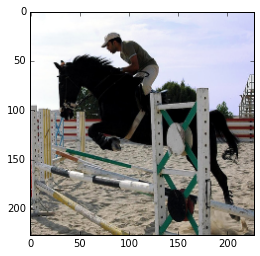

In [4]:
% matplotlib inline
from copy import copy

image_index = 0 #Lets look at the first image in the batch.
plt.imshow(deprocess(copy(solver.net.blobs['data'].data[image_index, ...])))
gtlist = solver.net.blobs['label'].data[image_index, ...].astype(np.int)
classes = ('__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')
print 'Ground truth: ',
for idx, val in enumerate(gtlist):
    if val and val != -1:
        print classes[idx] + ',',


In [5]:
%%time
solver.step(10)

CPU times: user 6.2 s, sys: 827 ms, total: 7.02 s
Wall time: 3.89 s


In [ ]:
ig_label = -1
def hamming_distance(gt, est):
    return sum([1 for (g, e) in zip(gt, est) if g == e and g != ig_label]) / float(len(gt[np.where(gt != ig_label)]))

def check_accuracy(net, num_batches, batch_size = 128):
    acc = 0.0
    for t in range(num_batches):
        net.forward()
        gts = net.blobs['label'].data
        ests = net.blobs['score'].data > 0
        for gt, est in zip(gts, ests): #for each ground truth and estimated label vector
            acc += hamming_distance(gt, est)
    return acc / (num_batches * batch_size)

In [ ]:
for itt in range(500):
    solver.step(1)
    if itt % 50 == 0:
        print 'itt:{}'.format(itt), 'accuracy:{0:.4f}'.format(check_accuracy(solver.test_nets[0], 10))

In [ ]:
def check_baseline_accuracy(net, num_batches, batch_size = 128):
    acc = 0.0
    for t in range(num_batches):
        net.forward()
        gts = net.blobs['label'].data
        ests = np.zeros((batch_size, len(gts)))
        for gt, est in zip(gts, ests): #for each ground truth and estimated label vector
            acc += hamming_distance(gt, est)
    return acc / (num_batches * batch_size)

print 'Baseline accuracy:{0:.4f}'.format(check_baseline_accuracy(solver.test_nets[0], 5823/128))

In [ ]:
% matplotlib inline
from copy import copy

image_index = 0 #Lets look at the first image in the batch.
test_net = solver.test_nets[0]
test_net.forward()
plt.imshow(deprocess(copy(test_net.blobs['data'].data[image_index, ...])))
gtlist = test_net.blobs['label'].data[image_index, ...].astype(np.int)
estlist = test_net.blobs['score'].data[image_index, ...] > 0
classes = ('__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')
print 'Ground truth: ',
for idx, val in enumerate(gtlist):
    if val and val != -1:
        print classes[idx] + ',',

print ''  
print 'Estimated: ',
for idx, val in enumerate(estlist):
    if val == 1:
        print classes[idx] + ',',